# Network Analysis on Auckland road data
### Import packages

In [2]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools

### Generating or importing the road network

In [13]:
G = ox.graph.graph_from_address("Auckland, New Zealand", network_type="walk", simplify = False, dist =200)

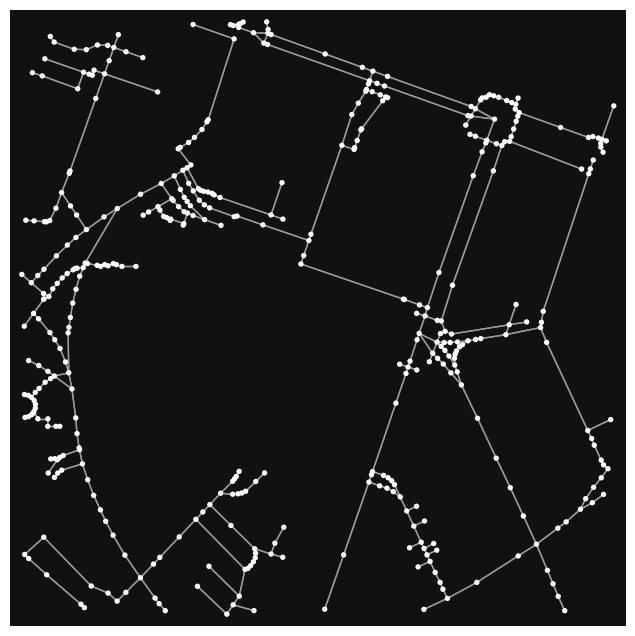

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [14]:
ox.plot_graph(G)

In [18]:
grid[["ne_u","ne_v","ne_dist"]] = ox.distance.nearest_edges(G, X=grid["lon"], Y=grid["lat"], interpolate=1)
grid.head(5)

,income,no_households,maori_pr,dampness,geometry,lon,lat,ne_u,ne_v,ne_dist
0,36794.543326,98.127690,0.057289,106.352366,POINT (227654.838 659745.889),227654.838387,659745.888519,1417624613,9694038595,0
1,35878.211275,102.782137,0.069748,122.412572,POINT (227779.681 659745.889),227779.681269,659745.888519,5548353304,5548353308,0
2,27770.128835,86.412036,0.053030,123.776598,POINT (227904.524 659745.889),227904.524150,659745.888519,1417624613,9694038595,0
3,38967.926453,105.735415,0.044627,88.687944,POINT (227529.996 659870.731),227529.995506,659870.731400,6993750594,5548353313,0
4,34764.978764,110.045951,0.062813,107.494800,POINT (227654.838 659870.731),227654.838387,659870.731400,8732335384,8732335383,0


<AxesSubplot: >

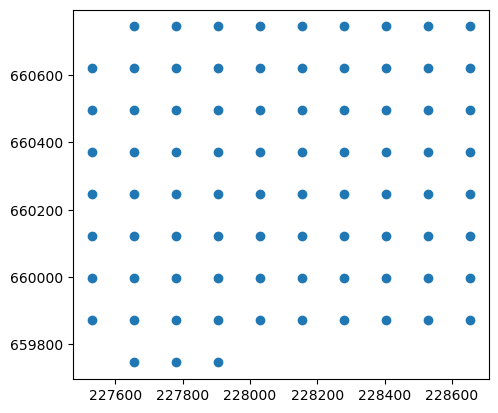

In [19]:
grid.plot()

In [15]:
# save for future use
ox.io.save_graphml(G, filepath="data/network_analysis/auckland_network_walk_unconsolidated.graphml", gephi=False, encoding='utf-8')

In [ ]:
ox.io.save_graph_geopackage(G, "data/network_analysis/auckland_network_walk_unconsolidated_gpkg.gpkg")

### Consolidate the newtork to solve the spatial/topological issue

In [55]:
G = ox.simplification.consolidate_intersections(G, rebuild_graph=True)

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:426: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = utils_graph.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/simplification.py:474: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


### Save the newtork for later analysis, cos it took long to download it

In [115]:
ox.io.save_graphml(G, filepath="data/auckland_network_walk_consolidated.graphml", gephi=False, encoding='utf-8')
ox.io.save_graph_geopackage(G, "data/network_analysis/gpkg_auckland_network_walk_consolidated.gpkg")

In [3]:
# get the nodes and the edges into geopandas
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

### Nearest distances

In [ ]:
# define function for the nearest neighbour
def nearest_node(a,b):
    nearest_node,dist=ox.distance.nearest_nodes(avon, (a,b), return_dist=True, method = 'euclidean')  
    return nearest_node

# Adding other data
### Import the grid of urban Auckland including census variables
The IDW was done in R. Code in the file data-prep.R

<AxesSubplot: >

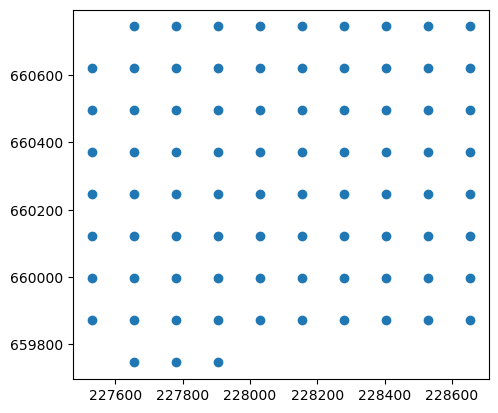

In [15]:
grid = gpd.read_file("data/geographic/grids/sample.gpkg")
grid['lon'] = grid['geometry'].x
grid['lat'] = grid['geometry'].y
grid.plot()

### Snap the grid of points to the nearest road egde
This is so that I can later calculate network distances between each point to the supply points

In [124]:
grid[["ne_u","ne_v","ne_dist"]] = ox.distance.nearest_edges(G, X=grid["lon"], Y=grid["lat"])
grid.head()

,income,no_households,maori_pr,dampness,geometry,lon,lat,ne_u,ne_v,ne_dist
0,36710.691419,50.796403,0.201352,127.790087,POINT (225532.509 609808.736),225532.509406,609808.736016,9872095432,7543967816,0
1,36882.949283,50.309440,0.198384,126.097575,POINT (225657.352 609808.736),225657.352287,609808.736016,9872095432,7543967816,0
2,37549.885003,48.335262,0.197472,124.746673,POINT (225782.195 609808.736),225782.195169,609808.736016,9872095432,7543967816,0
3,38054.679447,47.356256,0.189796,117.682066,POINT (225907.038 609808.736),225907.038050,609808.736016,9872095432,7543967816,0
4,38253.993943,47.114833,0.185706,115.530078,POINT (226031.881 609808.736),226031.880931,609808.736016,9872095432,7543967816,0


Save the grid with nearest edge for future use

In [125]:
grid.to_file("data/geographic/grids/grid_50000_auckland_census.gpkg", layer='grid', driver="GPKG")

### Import the train stations in Auckland
The IDW was done in R. Code in the file data-prep.R

<AxesSubplot: >

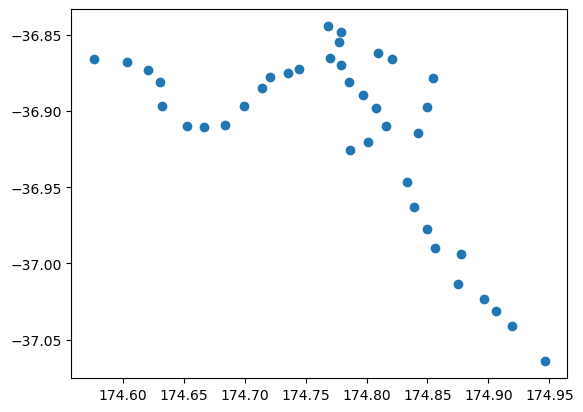

In [104]:
stations = gpd.read_file("data/transport/public_transport/trains_auckland.gpkg")
stations['lon'] = stations['geometry'].x
stations['lat'] = stations['geometry'].y
stations.plot()

### Snap the train station points to the nearest road egde
This is for later calculation of network distances between each station to the demand points - grid

In [105]:
stations[["u", "v", "dist"]] = ox.distance.nearest_edges(G, X=stations["lon"], Y=stations["lat"])
stations.head()

/opt/miniconda3/envs/ox/lib/python3.10/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))


,OBJECTID,STOPID,STOPCODE,STOPNAME,STOPDESC,LOCATIONTYPE,STOPLAT,STOPLON,PARENTSTATION,MODE,geometry,lon,lat,u,v,dist
0,1,97,97,Papakura Train Station,None,Stop,-37.064294,174.946114,None,Train,POINT (174.94611 -37.06429),174.946114,-37.064294,1071743678,5882816768,0
1,2,98,98,Manurewa Train Station,None,Stop,-37.023268,174.896171,None,Train,POINT (174.89617 -37.02327),174.896171,-37.023268,3843898501,7870811398,0
2,3,125,125,Henderson Train Station,None,Stop,-36.880965,174.630910,None,Train,POINT (174.63091 -36.88097),174.630910,-36.880965,8323389695,711693102,0
3,4,127,127,Swanson Train Station,None,Stop,-36.866181,174.576300,None,Train,POINT (174.57630 -36.86618),174.576300,-36.866181,9393064946,3490204785,0
4,5,113,113,Greenlane Train Station,None,Stop,-36.889657,174.797419,None,Train,POINT (174.79742 -36.88966),174.797419,-36.889657,26010886,26010873,0


In [107]:
stations.to_file("data/transport/public_transport/trains_auckland_with_distances_on_network.gpkg", layer='grid', driver="GPKG")